
# Working with coolers

In this notebook, we use files generated by the workflow `master_workflow` that, in short does:

1) Download the data from the source
2) Index the reference genome with `bwa index` and `samtools faidx`
3) Align the reads to the reference genome with `bwa mem`
4) Pair and sort the reads to `.pairs` files with `pairtools parse | pairtools sort`
5) Deduplicate the pairs with `pairtools dedup`
6) Convert the .pairs to cooler files with `cooler cload pairs`

We will:

1) Load the cooler files
2) Merge the coolers from the same BioSample ID --> Create 'replicates'
3) Zoomify the merged cooler files (coarsen) to create a multicooler (.mcool) file
4) Balance the matrices (use commandline `cooler balance`)
5) Calculate E1 compartments with `cooltools compute_cis_eig`

## Overview

### Data (Accessions)

In [116]:
#| echo: false

import pandas as pd

df = pd.read_csv('../data/SraRunTable.txt')[['source_name','Run', 'BioSample', 'Bases','Bytes']].sort_values(['source_name', 'Run'])
df['GB'] = df['Bytes'].apply(lambda x: x / (1024 ** 3))
df['Reads'] = df['Bases']/300
df = df[['source_name', 'BioSample', 'Run', 'GB', 'Bases', 'Reads']]

# Use the style method to format the columns for display
df1 = df.style.format({'Bases': '{:,.0f}', 'Reads': '{:,.0f}'})

df_grouped = df.groupby('source_name').agg({'GB': 'sum', 'Bases': 'sum', 'Reads': 'sum'}).reset_index()

display(df1, df_grouped)


,source_name,BioSample,Run,GB,Bases,Reads
16,fibroblast,SAMN08375237,SRR6502335,29.771059,"73,201,141,800","244,003,806"
17,fibroblast,SAMN08375237,SRR6502336,22.755361,"65,119,970,100","217,066,567"
18,fibroblast,SAMN08375236,SRR6502337,21.434722,"52,769,196,300","175,897,321"
19,fibroblast,SAMN08375236,SRR6502338,21.420030,"52,378,949,100","174,596,497"
20,fibroblast,SAMN08375236,SRR6502339,10.207410,"28,885,941,600","96,286,472"
9,fibroblast,SAMN08375237,SRR7349189,52.729173,"139,604,854,200","465,349,514"
10,fibroblast,SAMN08375236,SRR7349190,53.085520,"142,008,353,400","473,361,178"
21,pachytene spermatocyte,SAMN08375234,SRR6502342,60.258880,"150,370,993,500","501,236,645"
22,pachytene spermatocyte,SAMN08375234,SRR6502344,27.146048,"65,697,684,300","218,992,281"
23,pachytene spermatocyte,SAMN08375234,SRR6502345,26.202707,"63,490,538,700","211,635,129"


,source_name,GB,Bases,Reads
0,fibroblast,211.403275,553968406500,1.846561e+09
1,pachytene spermatocyte,274.835160,715656614700,2.385522e+09
2,round spermatid,243.128044,655938457200,2.186462e+09
3,sperm,164.131640,428913635400,1.429712e+09
4,spermatogonia,192.794420,518665980300,1.728887e+09


### Folder structure

In [1]:
#| echo: false

!tree -d -L 2 ../steps/bwa/PE

../steps/bwa/PE
├── bamfiles
│   ├── fibroblast
│   ├── pachytene_spermatocyte
│   ├── round_spermatid
│   ├── sperm
│   └── spermatogonia
├── cool
│   ├── fibroblast
│   ├── pachytene_spermatocyte
│   ├── round_spermatid
│   ├── sperm
│   └── spermatogonia
└── pairs
    ├── fibroblast
    ├── pachytene_spermatocyte
    ├── round_spermatid
    ├── sperm
    └── spermatogonia

18 directories


## FullMerge (pool all from each source_name)

With `cooler merge`. 

We will trust Wang et al. 2019 when they say that compartments are highly reprocible between replicates.

Thus, we will merge all samples from the same source_name into a single cooler file.

**Overview:** 
- Locate the coolers (`glob` --> dictionary)
- Merge the coolers (`cooler.merge_coolers`)
- Zoomify the merged cooler (`cooler.zoomify_cooler`) to resolutions: 10kb, 50kb, 100kb, 500kb. 
- Balance the matrices (`!cooler balance`) (use the CLI, as it is more easily parallelized)

### Create cooler dictionary (`glob`) 

In [2]:
import glob
import os.path as op
from pprint import pprint as pp

# Get the list of cell type dirs
base_dir = '../steps/bwa/PE/cool'
folders = glob.glob(op.join(base_dir, '*'))

files_dict = {f:glob.glob(f"{f}/*.nodups.*") for f in folders}
cooler_dict = {op.basename(k): [op.basename(f) for f in v] for k,v in files_dict.items()}
pp(cooler_dict)

{'fibroblast': ['SRR6502339.nodups.10000.cool',
                'SRR7349190.nodups.10000.cool',
                'SRR7349189.nodups.10000.cool',
                'SRR6502335.nodups.10000.cool',
                'SRR6502338.nodups.10000.cool',
                'SRR6502336.nodups.10000.cool',
                'SRR6502337.nodups.10000.cool'],
 'pachytene_spermatocyte': ['SRR7345459.nodups.10000.cool',
                            'SRR6502344.nodups.10000.cool',
                            'SRR6502342.nodups.10000.cool',
                            'SRR7345458.nodups.10000.cool',
                            'SRR6502345.nodups.10000.cool',
                            'SRR7349191.nodups.10000.cool'],
 'round_spermatid': ['SRR7349192.nodups.10000.cool',
                     'SRR6502353.nodups.10000.cool',
                     'SRR6502352.nodups.10000.cool',
                     'SRR6502351.nodups.10000.cool',
                     'SRR7345460.nodups.10000.cool',
                     'SRR7345461.nodu

### Merge coolers

We iterate through the dictionary and merge the coolers with `cooler merge`.

The `mergebuf` parameter should be adjusted if you don't have 32G memory. Default: `mergebuf = 20000000`.

Below, we also check if the output file already exists. If it does, we skip the merge.

In [5]:
# NB adjust `mergebuf` if you don't have 32G of RAM

import cooler

for folder,cooler_list in cooler_dict.items():
    in_uris = [op.join(base_dir, folder, file) for file in cooler_list]
    out_uri = op.join(base_dir, folder, f'{folder}.fullmerge.cool')

    if op.exists(out_uri):
        print(f"Skipping {out_uri}: exists...")
        continue

    print(f"Creating {out_uri} by \nMerging {len(cooler_list)} coolers into one:", end=" ")
    print("\t",[file.split('.')[0] for file in cooler_list])
    cooler.merge_coolers(output_uri=out_uri,
                         input_uris=in_uris,
                         mergebuf=int(5e7),
                         )
    print("... Done!")

Skipping ../steps/bwa/PE/cool/round_spermatid/round_spermatid.fullmerge.cool: exists...
Skipping ../steps/bwa/PE/cool/spermatogonia/spermatogonia.fullmerge.cool: exists...
Skipping ../steps/bwa/PE/cool/sperm/sperm.fullmerge.cool: exists...
Skipping ../steps/bwa/PE/cool/fibroblast/fibroblast.fullmerge.cool: exists...
Skipping ../steps/bwa/PE/cool/pachytene_spermatocyte/pachytene_spermatocyte.fullmerge.cool: exists...


### Zoomify the merged cooler files

Here, we zoomify the merged cooler files to resolutions: 10kb, 50kb, 100kb, 500kb.

In [7]:
# NB 8 cores and 32G of RAM was used

import glob
import cooler
import os.path as op

base_dir = '../steps/bwa/PE/cool'
merged_coolers = glob.glob(op.join(base_dir, '*/*.fullmerge.cool'))


for clr in merged_coolers:
    out_uri = clr.replace('.fullmerge.cool', '.mcool')
    if op.exists(out_uri):
        print(f"Skipping {out_uri}: exists...")
        continue

    print(f"Zoomifying cooler: \n\t   {clr}\n\t-> {out_uri}", end="")
    
    cooler.zoomify_cooler(base_uris = clr,
                          outfile = out_uri,
                          resolutions = [10000,50000,100000,500000],
                          chunksize = 10000000,
                          nproc = 8)
    print(" --> done")

Skipping ../steps/bwa/PE/cool/round_spermatid/round_spermatid.mcool: exists...
Skipping ../steps/bwa/PE/cool/spermatogonia/spermatogonia.mcool: exists...
Skipping ../steps/bwa/PE/cool/sperm/sperm.mcool: exists...
Zoomifying cooler: 
	   ../steps/bwa/PE/cool/fibroblast/fibroblast.fullmerge.cool
	-> ../steps/bwa/PE/cool/fibroblast/fibroblast.mcool --> done
Skipping ../steps/bwa/PE/cool/pachytene_spermatocyte/pachytene_spermatocyte.mcool: exists...


In [19]:
import glob
mcools = glob.glob("../steps/bwa/PE/cool/*/*.mcool")

for mcool in mcools:
    print(f"{mcool}:")
    print(cooler.fileops.list_coolers(mcool))
    print()



../steps/bwa/PE/cool/round_spermatid/round_spermatid.mcool:
['/resolutions/10000', '/resolutions/50000', '/resolutions/100000', '/resolutions/500000']

../steps/bwa/PE/cool/spermatogonia/spermatogonia.mcool:
['/resolutions/10000', '/resolutions/50000', '/resolutions/100000', '/resolutions/500000']

../steps/bwa/PE/cool/sperm/sperm.mcool:
['/resolutions/10000', '/resolutions/50000', '/resolutions/100000', '/resolutions/500000']

../steps/bwa/PE/cool/fibroblast/fibroblast.mcool:
['/resolutions/10000', '/resolutions/50000', '/resolutions/100000', '/resolutions/500000']

../steps/bwa/PE/cool/pachytene_spermatocyte/pachytene_spermatocyte.mcool:
['/resolutions/10000', '/resolutions/50000', '/resolutions/100000', '/resolutions/500000']



0    chr1
Name: chrom, dtype: category
Categories (22, object): ['chr1' < 'chr2' < 'chr3' < 'chr4' ... 'chr19' < 'chr20' < 'chrX' < 'chrY']

0    0
Name: start, dtype: int32

0    500000
Name: end, dtype: int32

0    0.002814
Name: weight, dtype: float64

### Balance the matrices

In [2]:
%capture --no-stdout

import glob

mcools = glob.glob("../steps/bwa/PE/cool/*/*.mcool")
resolutions = [10000, 50000, 100000, 500000]

for mcool in mcools:
    print(f"Balancing {mcool}:")
    for res in resolutions:
        full_name = f"{mcool}::resolutions/{res}"
        print(f"\tresolution {res}...", end=" ")
        # First, just default values
        #!cooler balance -p 32 {full_name}
        # With more filtering
        !cooler balance -p 32 -c 20000000 --cis-only -n cis_weights {full_name}
        print("--> Done!")

Balancing ../steps/bwa/PE/cool/round_spermatid/round_spermatid.mcool:
	resolution 10000... 

INFO:cooler.cli.balance:Balancing "../steps/bwa/PE/cool/round_spermatid/round_spermatid.mcool::resolutions/10000"
INFO:cooler.balance:variance is 2079661.4027216053
INFO:cooler.balance:variance is 453553.06527791504
INFO:cooler.balance:variance is 122090.58632047936
INFO:cooler.balance:variance is 129190.84140421994
INFO:cooler.balance:variance is 48191.01921909741
INFO:cooler.balance:variance is 40764.260723976775
INFO:cooler.balance:variance is 18356.248248008043
INFO:cooler.balance:variance is 13507.74990364802
INFO:cooler.balance:variance is 6807.56897366601
INFO:cooler.balance:variance is 4602.949620233886
INFO:cooler.balance:variance is 2481.4615818257016
INFO:cooler.balance:variance is 1594.394282252964
INFO:cooler.balance:variance is 894.8193883950739
INFO:cooler.balance:variance is 557.6097513200839
INFO:cooler.balance:variance is 320.5395715985926
INFO:cooler.balance:variance is 196.1207825649443
INFO:cooler.balance:variance is 114.360455989492
INFO:cooler.balance:variance is

## RepMerge (pool all from each BioSample ID)

Merge into the original 'replicates' 

In [1]:
#df.groupby(['source_name','BioSample'])['Reads'].sum()

In [2]:
# from pprintpp import pprint as pp

# grouped_df = df.groupby(['source_name','BioSample'])

# # Initialize an empty dictionary
# rep_dict = {}

# # Iterate over each group
# for (source_name, BioSample), group in grouped_df:
#     # Extract the 'Run' column and convert it to a list
#     run_list = group['Run'].tolist()
    
#     # Populate the nested dictionary
#     if source_name not in rep_dict:
#         rep_dict[source_name] = {}
#     rep_dict[source_name][BioSample] = run_list

# pp(rep_dict)

In [3]:
# for source_name, BioSample_dict in rep_dict.items():
#     print(f"source_name: {source_name}")
#     print(f"Changing working dir: {source_name}/")
#     for BioSample, run_list in BioSample_dict.items():
#         print(f"Merging samples for BioSample: {BioSample}: {run_list}")

# Plotting

## 500kb resolution

### Example with a single sample

#### Imports

In [74]:
# import standard python libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import os, subprocess

In [75]:
# Import python package for working with cooler files and tools for analysis
import cooler
import cooltools.lib.plotting
import cooltools

#### Load cooler

In [65]:
cool_file = "../steps/bwa/PE/cool/fibroblast/fibroblast.mcool"

clr = cooler.Cooler(f"{cool_file}::resolutions/500000")

#### Calculate gc covariance (from the reference genome)

In [67]:
import bioframe
import os

bins = clr.bins()[:]
rheMac10 = bioframe.load_fasta('../data/links/ucsc_ref/rheMac10.fa')
if not os.path.exists('rheMac10_gc_cov_500kb.tsv'):
    print('Calculate the fraction of GC basepairs for each bin')
    gc_cov = bioframe.frac_gc(bins[['chrom', 'start', 'end']], rheMac10)
    gc_cov.to_csv('rheMac10_gc_cov_500kb.tsv', index=False,sep='\t')
    display(gc_cov)
else: 
    print("Already exists, just read from file:")
    gc_cov = pd.read_csv("rheMac10_gc_cov_500kb.tsv", sep='\t')
    display(gc_cov)

Already exists, just read from file:


,chrom,start,end,GC
0,chr1,0,500000,0.424508
1,chr1,500000,1000000,0.378836
2,chr1,1000000,1500000,0.388272
3,chr1,1500000,2000000,0.445226
4,chr1,2000000,2500000,0.439485
...,...,...,...,...
5715,chrY,9500000,10000000,0.399518
5716,chrY,10000000,10500000,0.396028
5717,chrY,10500000,11000000,0.395280
5718,chrY,11000000,11500000,0.382006


In [68]:
# Apparently, we have som NaN values, I don't know why (and only 1 on the X)
gc_cov[gc_cov['GC'].isna()].groupby('chrom').size()

chrom
chr1     1
chr10    1
chr11    1
chr12    1
chr13    1
chr14    1
chr15    1
chr16    1
chr17    1
chr18    1
chr19    1
chr2     1
chr20    1
chr3     1
chr4     1
chr5     1
chr6     1
chr7     1
chr8     1
chr9     1
chrY     1
dtype: int64

In [69]:
view_df = pd.DataFrame(
    {
    'chrom': clr.chromnames,
    'start': 0,
    'end': clr.chromsizes.values,
    'name': clr.chromnames
    }
                      )
#display(view_df)

In [70]:
# obtain first 3 eigenvectors
cis_eigs = cooltools.eigs_cis(
                        clr,
                        gc_cov,
                        view_df=view_df,
                        n_eigs=3,
                        )

# cis_eigs[0] returns eigenvalues, here we focus on eigenvectors
eigenvector_track = cis_eigs[1][['chrom','start','end','E1']]
len(eigenvector_track)

5720

In [71]:
# full track
eigenvector_track

,chrom,start,end,E1
0,chr1,0,500000,-0.756052
1,chr1,500000,1000000,-1.001063
2,chr1,1000000,1500000,-0.928042
3,chr1,1500000,2000000,-0.507579
4,chr1,2000000,2500000,0.123708
...,...,...,...,...
5715,chrY,9500000,10000000,-0.499798
5716,chrY,10000000,10500000,-0.588820
5717,chrY,10500000,11000000,-0.988677
5718,chrY,11000000,11500000,-0.566585


In [72]:
# subset the chrX   
eigenvector_track_chrX = eigenvector_track.loc[eigenvector_track['chrom'] == 'chrX']
nbins = len(eigenvector_track_chrX)
eigenvector_track_chrX
e1X_values = eigenvector_track_chrX['E1'].values

In [97]:

np.where(np.diff( (cis_eigs[1][cis_eigs[1]['chrom']=='chrX']['E1']>0).astype(int)))[0]

array([  1,   6,  16,  26,  29,  40,  42,  49,  54,  55,  59,  60,  61,
        62,  74,  83,  86, 101, 102, 103, 104, 108, 123, 124, 129, 138,
       141, 142, 147, 149, 185, 188, 194, 196, 197, 201, 206, 209, 211,
       215, 222, 224, 228, 233, 238, 240, 250, 253, 256, 265, 273, 274,
       288, 289, 290, 293, 296, 302])

In [99]:
%%capture chrX_matrix_e1_500kb

from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

f, ax = plt.subplots(
    figsize=(15, 10),
)

norm = LogNorm(vmax=0.1)

im = ax.matshow(
    clr.matrix().fetch('chrX'),
    norm=norm,
    cmap='fall',
);
plt.axis([0,nbins,nbins,0])


divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax, label='corrected frequencies');
ax.set_ylabel('chrX:500kb bins, #bin')
ax.xaxis.set_visible(False)

ax1 = divider.append_axes("top", size="20%", pad=0.25, sharex=ax)
weights = clr.bins()[:]['weight'].values
#ax1.plot([0,nbins],[0,0],'k',lw=0.25)

#ax1.plot(e1X_values, label='E1')

# Fill between the line and 0
ax1.fill_between(range(len(e1X_values)), e1X_values, 0, where=(e1X_values > 0), color='tab:red')
ax1.fill_between(range(len(e1X_values)), e1X_values, 0, where=(e1X_values < 0), color='tab:blue')

ax1.set_ylabel('E1')
ax1.set_xticks([]);


for i in np.where(np.diff( (cis_eigs[1][cis_eigs[1]['chrom']=='chrX']['E1']>0).astype(int)))[0]:
    # Horisontal lines where E1 intersects 0
    #ax.plot([0,nbins],[i,i],'k',lw=0.5)

    # Vertical lines where E1 intersects 0
    ax.plot([i,i],[0,nbins],'k',lw=0.3)

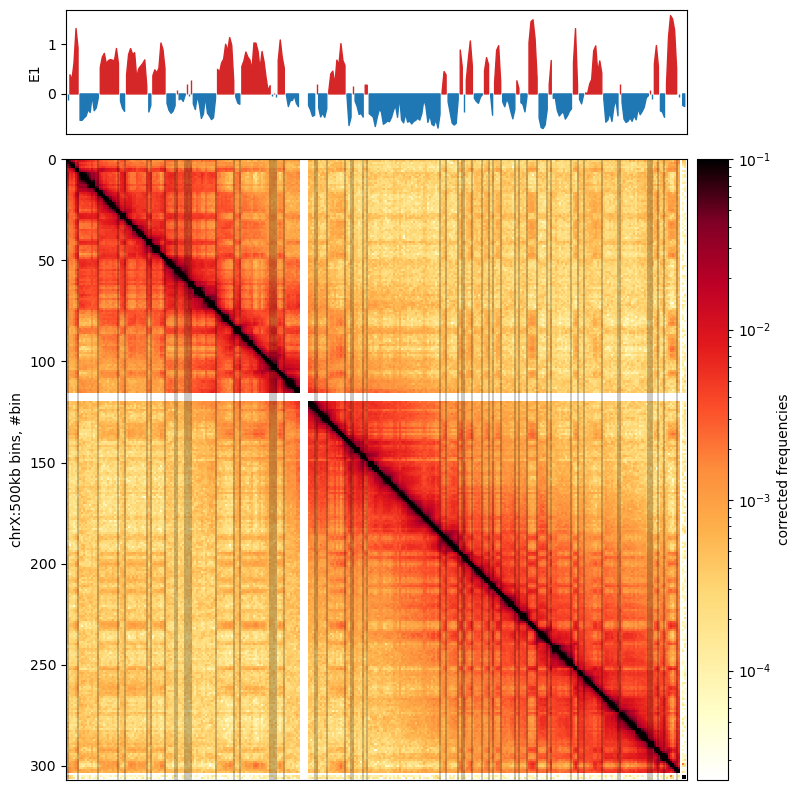

In [100]:
#| label: chrX-matrix-e1-500kb
#| fig-cap: "chrX interaction matrix with E1 eigenvector values. 500kb resolution"

chrX_matrix_e1_500kb()

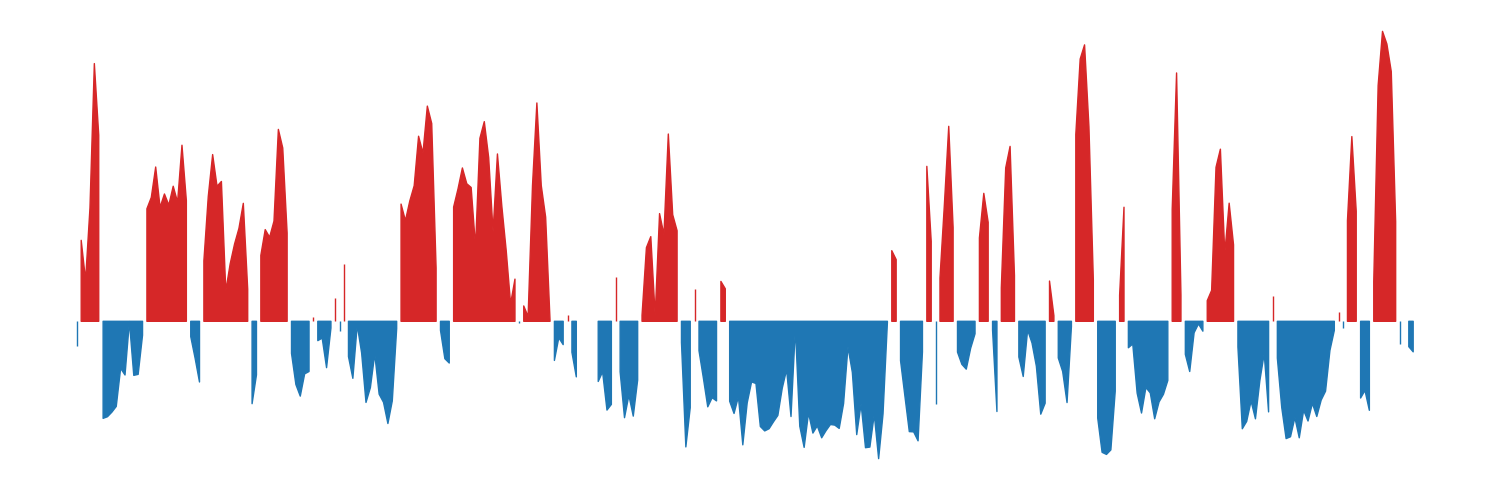

In [38]:
#| label: chrX-e1-500kb-plot
#| fig-cap: "500kb binned E1 eigenvector values for chrX. Freshly calculated from the cooler file."
#| fig-height: 1


import matplotlib.pyplot as plt

f, ax1 = plt.subplots(
    figsize=(15, 5),
)

# Fill between the line and 0
ax1.fill_between(range(len(e1X_values)), e1X_values, 0, where=(e1X_values > 0), color='tab:red')
ax1.fill_between(range(len(e1X_values)), e1X_values, 0, where=(e1X_values < 0), color='C0')

#ax1.set_ylabel('E1')
ax1.set_xticks([])
ax1.set_yticks([])

# Remove borders
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

plt.tight_layout()

# Save the plot as a high-resolution PNG file
#plt.savefig('e1_plot.png', dpi=320, bbox_inches='tight')

plt.show()

#### Stairs plot of the E1 compartments

(Less spiky, more smooth)



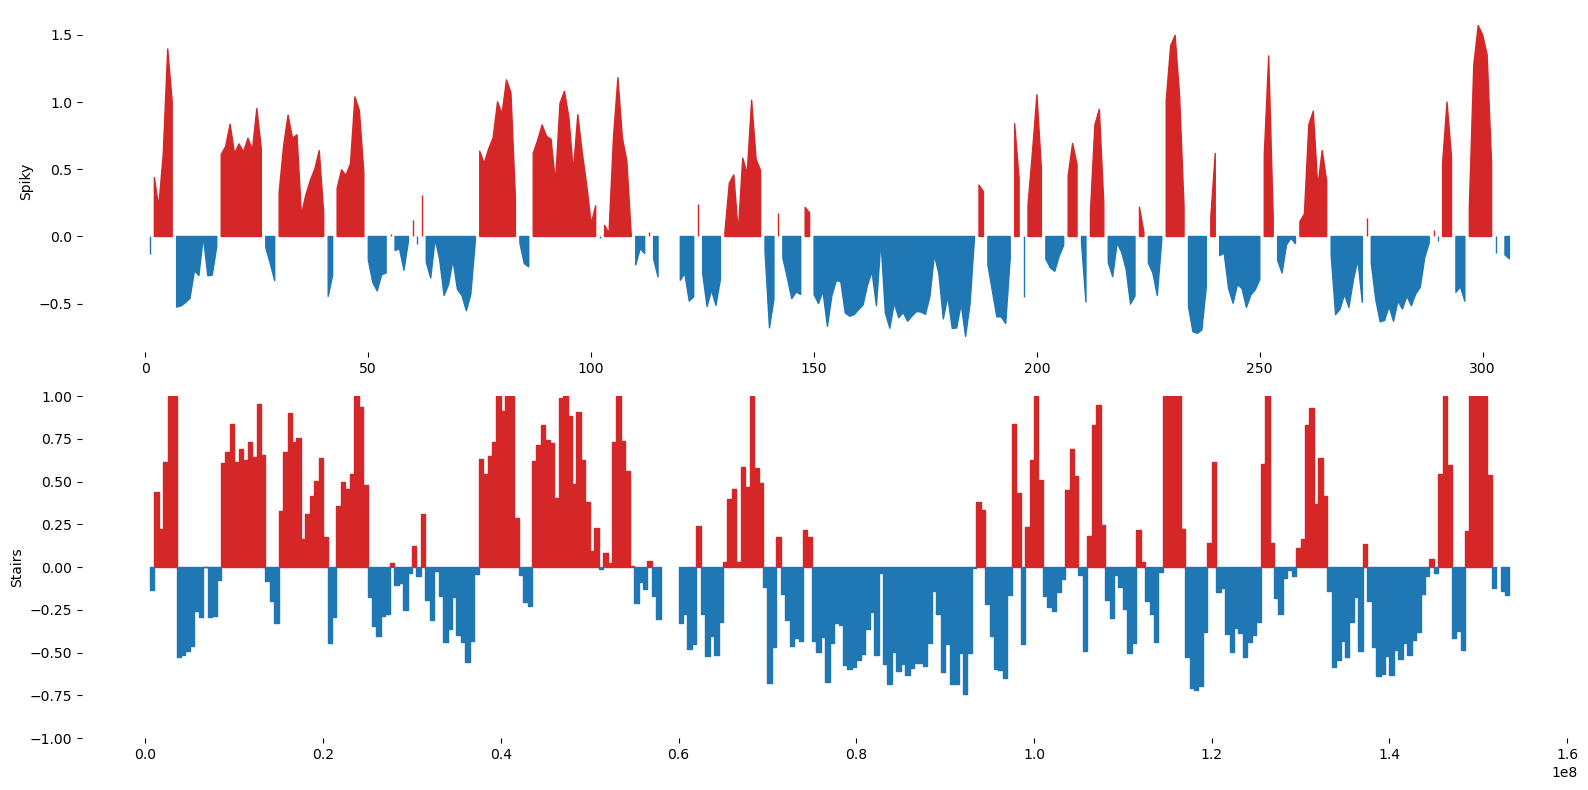

In [36]:
#| label: chrX-e1-500kb-stairs
#| fig-cap: "500kb binned E1 eigenvector values for chrX."
#| fig-height: 2


import matplotlib.pyplot as plt

f, (ax1, ax2) = plt.subplots(2,1,
    figsize=(16, 8)
)

chrom_start = eigenvector_track_chrX['start'].values
window_size = chrom_start[1] - chrom_start[0]

# Fill between the line and 0
ax1.fill_between(range(len(e1X_values)), e1X_values, 0, where=(e1X_values > 0), color='tab:red')
ax1.fill_between(range(len(e1X_values)), e1X_values, 0, where=(e1X_values < 0), color='tab:blue')

# Create stairs
x = np.zeros(2*chrom_start.size)
y = np.zeros(2*chrom_start.size)
x[0::2] = chrom_start
x[1::2] = chrom_start + window_size
y[0::2] = e1X_values
y[1::2] = e1X_values

# Layout
ax1.set_ylabel('Spiky')
ax2.set_ylabel('Stairs')
#ax1.set_xticks([])
#ax1.set_yticks([])
ax2.set_ylim(-1, 1)

# Remove borders
ax1.spines[:].set_visible(False)
ax2.spines[:].set_visible(False)

ax2.fill_between(x, y, 0, where=(y > 0), color='tab:red')
ax2.fill_between(x, y, 0, where=(y < 0), color='tab:blue')

plt.tight_layout()
# Save the plot as a high-resolution PNG file
#plt.savefig('e1_plot.png', dpi=320, bbox_inches='tight')



### All 5 full merges

#### Load coolers

In [56]:
import glob
import os.path as op
import cooler

mcools = glob.glob("../steps/bwa/PE/cool/*/*.mcool")
res = "::resolutions/500000"

clrs = {op.basename(op.dirname(mcool)): cooler.Cooler(mcool+res) for mcool in mcools}

chron_order = ['fibroblast', 'spermatogonia', 'pachytene_spermatocyte', 'round_spermatid', 'sperm']

clrs = {key: clrs[key] for key in chron_order}
clrs

{'fibroblast': <Cooler "fibroblast.mcool::/resolutions/500000">,
 'spermatogonia': <Cooler "spermatogonia.mcool::/resolutions/500000">,
 'pachytene_spermatocyte': <Cooler "pachytene_spermatocyte.mcool::/resolutions/500000">,
 'round_spermatid': <Cooler "round_spermatid.mcool::/resolutions/500000">,
 'sperm': <Cooler "sperm.mcool::/resolutions/500000">}

#### Calculate gc covariance (from the reference genome)

Do this with any of the clrs - it just needs the bins positions.

In [57]:
# Try with only the gc_cov for chrX

import bioframe
import pandas as pd

bins = clrs['fibroblast'].bins().fetch('chrX')[:]
out_name = 'rheMac10_gc_cov_X_500kb.tsv'

rheMac10 = bioframe.load_fasta('../data/links/ucsc_ref/rheMac10.fa')
if not op.exists(out_name):
    print('Calculate the fraction of GC basepairs for each bin')
    gc_cov = bioframe.frac_gc(bins[['chrom', 'start', 'end']], rheMac10)
    gc_cov.to_csv(out_name, index=False,sep='\t')
    print(gc_cov.info())
else: 
    print("Already exists, read from file")
    gc_cov = pd.read_csv(out_name, sep='\t')
    print(gc_cov.info())

Already exists, read from file
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307 entries, 0 to 306
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   chrom   307 non-null    object 
 1   start   307 non-null    int64  
 2   end     307 non-null    int64  
 3   GC      307 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 9.7+ KB
None


#### Calculate the E1 compartments

Loop: view_df, cis_eigs, e1_values

In [64]:
# Use gc_cov to calculate eigenvectors with cooltools.eigs_cis

import cooltools

eigs = {}
e1_values = {}

chrX_size = clrs['fibroblast'].chromsizes['chrX']

view_df = pd.DataFrame(
    {
    'chrom': ['chrX','chrX'],
    'start': [0, 60_000_001],
    'end': [60_000_000, chrX_size],
    'name': ['X_short', 'X_long']
    }, index=[0,1]
                      )

for name, clr in clrs.items():
    print(f"Calculating eigenvectors for {name}")
    cis_eigs = cooltools.eigs_cis(
                        clr,
                        gc_cov,
                        view_df=view_df,
                        n_eigs=3,
                        )
    eigs[name] = cis_eigs[1]
    e1_track = cis_eigs[1][['chrom','start','end','E1']]
    e1_values[name] = e1_track['E1'].values

eigs

153388924
Calculating eigenvectors for fibroblast
Calculating eigenvectors for spermatogonia


/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/cooltools/lib/common.py:489: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")
/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/cooltools/lib/common.py:489: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")


Calculating eigenvectors for pachytene_spermatocyte


/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/cooltools/lib/common.py:489: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")


Calculating eigenvectors for round_spermatid
Calculating eigenvectors for sperm


/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/cooltools/lib/common.py:489: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")
/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/cooltools/lib/common.py:489: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")


{'fibroblast':      chrom      start        end    weight        E1        E2        E3
 5389  chrX          0     500000       NaN       NaN       NaN       NaN
 5390  chrX     500000    1000000  0.004511 -0.242689  0.286959  0.482199
 5391  chrX    1000000    1500000  0.003583  0.289082  0.204193  0.497796
 5392  chrX    1500000    2000000  0.002596  0.202437  0.212595  0.474286
 5393  chrX    2000000    2500000  0.002528  0.527928  0.024045  0.236699
 ...    ...        ...        ...       ...       ...       ...       ...
 5691  chrX  151000000  151500000  0.004917  0.292930  1.127998  1.267946
 5692  chrX  151500000  152000000  0.004293 -0.240426  0.986415  1.051309
 5693  chrX  152000000  152500000       NaN       NaN       NaN       NaN
 5694  chrX  152500000  153000000  0.007404  0.140045 -1.624220 -1.332051
 5695  chrX  153000000  153388924  0.009796  0.126509 -1.592873 -1.293533
 
 [307 rows x 7 columns],
 'spermatogonia':      chrom      start        end    weight        E1 

,length,NaNs
fibroblast,307,6
spermatogonia,307,29
pachytene_spermatocyte,307,34
round_spermatid,307,15
sperm,307,6


(array([  0, 116, 117, 118, 119, 304]),)
(array([  0, 103, 110, 111, 113, 114, 115, 116, 117, 118, 119, 120, 121,
       122, 123, 126, 127, 137, 140, 146, 147, 150, 151, 298, 299, 300,
       302, 304, 306]),)
(array([  0,   1,   2, 103, 110, 111, 113, 114, 115, 116, 117, 118, 119,
       120, 121, 122, 123, 125, 126, 127, 128, 137, 140, 146, 147, 151,
       291, 298, 300, 302, 303, 304, 305, 306]),)
(array([  0, 113, 114, 115, 116, 117, 118, 119, 137, 147, 291, 298, 300,
       304, 306]),)
(array([  0, 115, 116, 117, 118, 119]),)


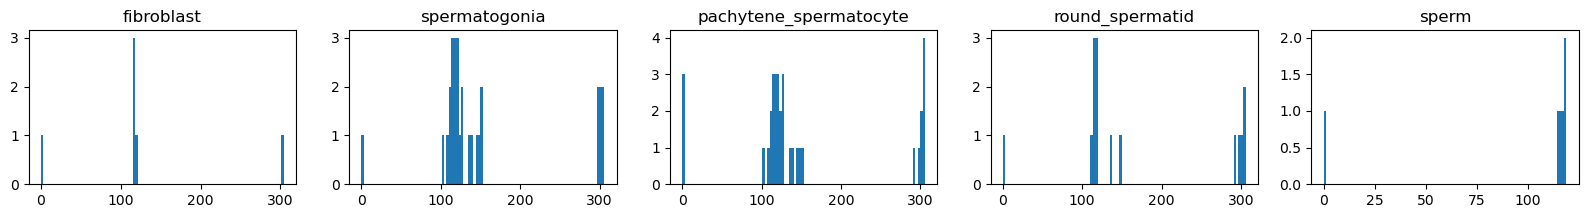

In [65]:
# Check the number of NaN values in the E1 column
import numpy as np

# Check the number of NaN values in the E1 column and create a DataFrame
nan_counts = {k: {'length': len(v), 'NaNs': np.isnan(v).sum()} for k, v in e1_values.items()}
display(pd.DataFrame.from_dict(nan_counts, orient='index'))

# Locate the NaN values (histogram)
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, 5, figsize=(20,2))
for i, (name, track) in enumerate(eigs.items()):
    e1 = track['E1'].values
    # Locate NaN values
    e1_nan = np.where(np.isnan(e1))
    print(e1_nan)
    ax[i].hist(e1_nan, bins=100)
    ax[i].set_title(name)
                     

#### Plot matrices with compartments

#### Plot the E1 compartments

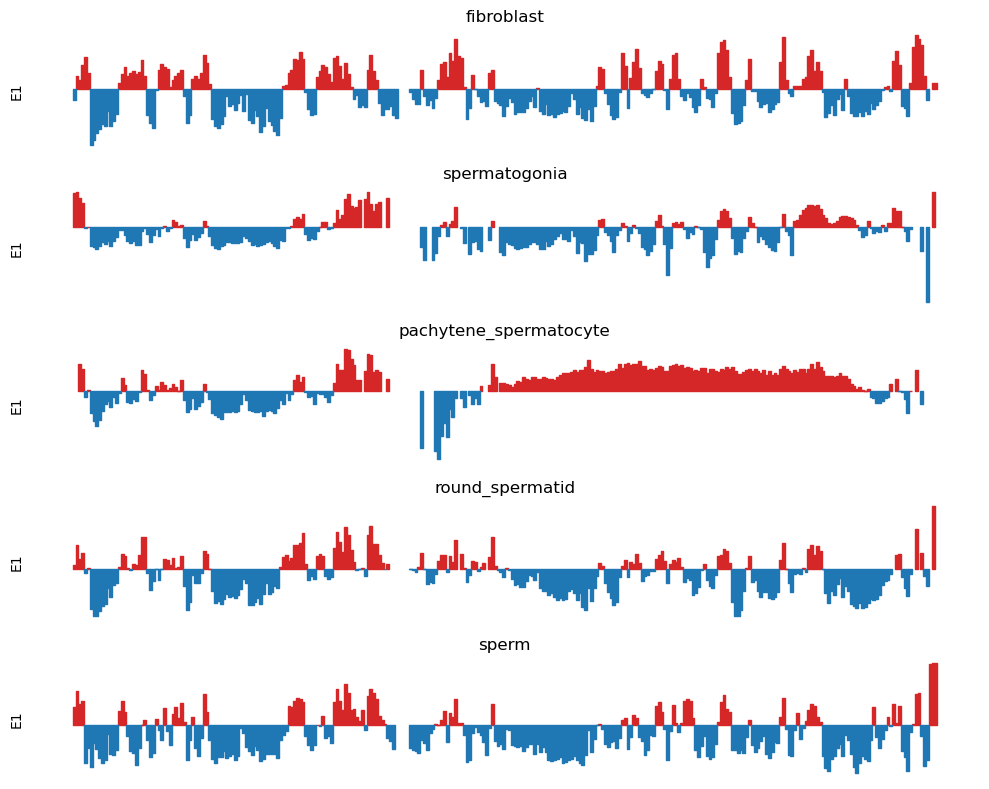

In [66]:
#| label: e1-fullmerged-all-500kb
#| fig-cap: "E1 eigenvector values for all merged samples at 500kb resolution."

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

chrom_start = e1_track['start'].values
chrom_end = e1_track['end'].values-1

f, axs = plt.subplots(5, 1, figsize=(10, 8), sharex=True)

for i, (name, e1) in enumerate(e1_values.items()):
    ax = axs[i]
    ax.set_title(name)
    
    # Create stairs
    x = np.zeros(2*chrom_start.size)
    y = np.zeros(2*chrom_start.size)
    x[0::2] = chrom_start
    x[1::2] = chrom_end
    y[0::2] = e1
    y[1::2] = e1

    ax.fill_between(x, y, 0, where=(y > 0), color='tab:red')
    ax.fill_between(x, y, 0, where=(y < 0), color='tab:blue')
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylabel("E1")
    ax.spines[:].set_visible(False)

plt.tight_layout()

#### Try Kasper's running average

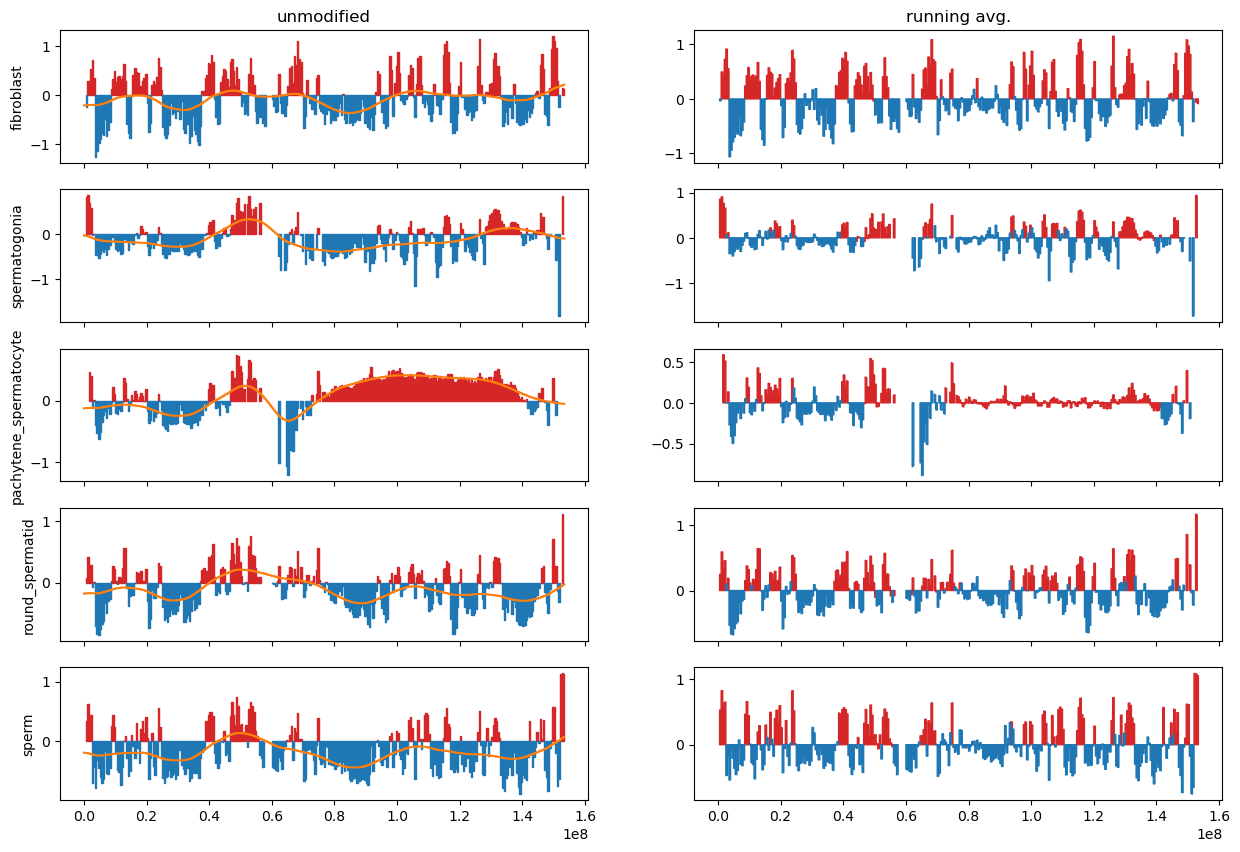

In [67]:
#| label: e1-fullmerged-all-500kb-running-avg
#| fig-cap: "E1 eigenvector values for all merged samples at 500kb resolution with running average."

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
from scipy.signal.windows import triang

chrom_start = e1_track['start'].values
chrom_end = e1_track['end'].values-1

f, axs = plt.subplots(5, 2, figsize=(15, 10), sharex=True)

axs[0, 0].set_title('unmodified')
axs[0, 1].set_title('running avg.')

for i, (name, e1) in enumerate(e1_values.items()):
    # print(i, name, e1.size)

    ax0 = axs[i, 0]
    ax1 = axs[i, 1]
    
    # Create stairs
    x = np.zeros(2*chrom_start.size)
    y = np.zeros(2*chrom_start.size)
    x[0::2] = chrom_start
    x[1::2] = chrom_end
    y[0::2] = e1_values[name]
    y[1::2] = e1_values[name]

    triangular_window = np.bartlett(120)
    #roll_mean = np.convolve(y, triangular_window / triangular_window.sum(), mode='same')
    roll_mean = (lambda x: x.rolling(120, 1, center=True, win_type='triang').mean())(pd.DataFrame(y, columns=['value']))
    roll_mean = roll_mean['value'].values

    ax0.fill_between(x, y, 0, where=(y > 0), color='tab:red')
    ax0.fill_between(x, y, 0, where=(y < 0), color='tab:blue')
    
    ax0.plot(x, roll_mean, color='C1')
    ax1.fill_between(x, y - roll_mean, 0, where=(y > 0), color='tab:red')
    ax1.fill_between(x, y - roll_mean, 0, where=(y < 0), color='tab:blue')

#     ax.set_xticks([])
#     ax.set_yticks([])
    ax0.set_ylabel(name)
#     ax.spines[:].set_visible(False)

# plt.tight_layout()

### Plot E2 compartments